# RL Problem Set 2

In [2]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt

# Basic Definitions and Utilities

In [4]:
# Basic properties of the MDP
N = 100  # Maximum length of the queue
A = 2  # Number of actions
gamma = 0.9  # Discount factor
p = 0.5  # Arrival rate of requests
q_low = 0.51  # Service rate for action alow
q_high = 0.6  # Service rate for action ahigh
c_low = 0  # Cost for action alow
c_high = 0.01  # Cost for action ahigh


# Reward function based on state x and action a
def reward(x, a):
    if a == 'alow':
        return -(x / N) ** 2
    elif a == 'ahigh':
        return -(x / N) ** 2 - c_high


# Truncate function to keep queue length within bounds
def trunc(x):
    return min(N - 1, max(x, 0))

# Phi functions for the three feature maps
def phi_fine(x, N):
    # Create a one-hot encoded vector for state x, where the vector has a length of N
    feature_vector = np.zeros(N)
    # Set the feature corresponding to the current state x to 1
    feature_vector[x] = 1
    return feature_vector

def phi_coarse(x, N):
    # Determine the number of bins
    num_bins = N // 5
    # Calculate the bin index for the current state x
    bin_index = x // 5
    # Create a feature vector with a length of num_bins
    feature_vector = np.zeros(num_bins)
    # Set the feature corresponding to the bin_index to 1
    feature_vector[bin_index] = 1
    return feature_vector

def phi_pwl(x, N):
    # Determine the number of bins
    num_bins = N // 5  
    # Create a feature vector with a length of 2 * num_bins
    feature_vector = np.zeros(2 * num_bins)
    # Calculate the bin index for the current state x
    bin_index = x // 5
    # Set the feature corresponding to the bin_index to 1 (coarse feature)
    feature_vector[bin_index] = 1
    # Calculate and set the piecewise linear feature
    position_in_bin = x % 5
    feature_vector[num_bins + bin_index] = position_in_bin / 5.0
    return feature_vector

## Problem 1: *Approximate Policy Evaluation*

### 1.1 Defining the two policies

In [5]:
# pi_lazy: always chooses the 'alow' action
pi_lazy = np.zeros((N, A))
pi_lazy[:, 0] = 1  # Always choose action alow 

# pi_aggressive: chooses 'alow' action for state less than 50 and 'ahigh' for states 50 and above
pi_aggressive = np.zeros((N, A))
pi_aggressive[:50, 0] = 1  # Choose action alow for x < 50
pi_aggressive[50:, 1] = 1  # Choose action ahigh for x >= 50

### 1.2 Sampling the next state

In [6]:
# Function to generate the next state based on the current state and action
def sample_transition(x, action):
    increment = np.random.choice([0, 1], p=[1 - p, p])  # Arrival of new request
    if action == 'alow':  # alow
        decrement = np.random.choice([0, 1], p=[1 - q_low, q_low])  # Service completion with low rate
    else:  # action == 'ahigh'
        decrement = np.random.choice([0, 1], p=[1 - q_high, q_high])  # Service completion with high rate

    new_x = trunc(x + increment - decrement)  # New state with truncation
    return new_x

### 1.3 TD(0) Weight Update

In [7]:
def TD0(policy, feature_map, alpha, num_transitions, gamma):
    w = np.zeros(feature_map(N - 1, N).shape)  # Initialize the weight vector

    # Initial state
    x = N - 1  # Start from a full queue
    for t in range(1, num_transitions + 1):
        # Determine the action based on the policy
        action = 'alow' if policy[x, 0] == 1 else 'ahigh'

        # Sample the transition
        x_prime = sample_transition(x, action)

        # Get the reward
        r = reward(x, action)

        # Calculate the TD(0) error
        phi_x = feature_map(x, N)
        phi_x_prime = feature_map(x_prime, N)
        td_error = r + gamma * np.dot(w, phi_x_prime) - np.dot(w, phi_x)

        # Update the weights - assume alpha is either a constant or a function that decays
        learning_rate = alpha(t) if callable(alpha) else alpha
        w += (learning_rate * td_error * phi_x)

        # Move to the new state
        x = x_prime

    # Return the learned weights
    return w

### 1.4 LSTD Weight Update

In [8]:
def LSTD(policy, feature_map, num_transitions, N, gamma):
    # Initialize variables
    d = len(feature_map(0, N))
    A = np.zeros((d, d))
    b = np.zeros(d)

    # Initialize state
    x = N - 1  # Start at the full queue

    for _ in range(num_transitions):
        # Choose action according to policy
        action = 'alow' if policy[x, 0] == 1 else 'ahigh'

        # Calculate the reward for the current state and action
        r = reward(x, action)

        # Compute feature vector for current state
        phi_x = feature_map(x, N)

        # Sample a transition to the next state
        x_next = sample_transition(x, action)

        # Compute feature vector for next state
        phi_x_next = feature_map(x_next, N)

        # Update A and b (recursive least squares update)
        A += np.outer(phi_x, (phi_x - gamma * phi_x_next))
        b += phi_x * r

        # Update state
        x = x_next

    # Solve for the weight vector w using the Moore-Penrose pseudoinverse
    w = np.linalg.pinv(A) @ b

    # Return the weight vector
    return w


### 1.5 Run Method to Run TD(0) and LSTD for a Given Policy and Feature Map

In [9]:
# Define the step size parameter function for TD(0)
def alpha(t, a=10 ** 5, b=10 ** 5):
    return a / (t + b)


def run_td0_lstd(policies, feature_maps):
    # Pre-allocate space for storing results
    results_td0 = {}
    results_lstd = {}
    sample_sizes = [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7]

    # Iterate over policies, feature maps, and sample sizes
    for policy_name, policy in policies.items():
        results_td0[policy_name] = {}
        results_lstd[policy_name] = {}

        for feature_map_name, feature_map in feature_maps.items():
            results_td0[policy_name][feature_map_name] = []
            results_lstd[policy_name][feature_map_name] = []

            for sample_size in sample_sizes:
                # Run TD(0)
                w_td0 = TD0(policy, feature_map, alpha, sample_size, gamma)
                print(
                    f'Finished TD(0) for {policy_name} policy and {feature_map_name} feature map with {sample_size} transitions')
                results_td0[policy_name][feature_map_name].append(w_td0)

                # Run LSTD
                w_lstd = LSTD(policy, feature_map, sample_size, N, gamma)
                print(
                    f'Finished LSTD for {policy_name} policy and {feature_map_name} feature map with {sample_size} transitions')
                results_lstd[policy_name][feature_map_name].append(w_lstd)

    return results_td0, results_lstd

### 1.6 Run TD(0) and LSTD for all combinations of policies and feature maps

#### 1.6.1 Run TD(0) and LSTD for the lazy policy and fine feature map

In [30]:
policies = {'lazy': pi_lazy}
feature_maps = {'fine': phi_fine}

# Pre-allocate space for storing results
results_td0 = {}
results_lstd = {}

# Run TD(0) and LSTD for the lazy policy and fine feature map
results_td0, results_lstd = run_td0_lstd(policies, feature_maps)
# Save the two dictionaries that are for pi_lazy and phi_fine to a file
np.savez('results_lazy_fine.npz', results_td0=results_td0, results_lstd=results_lstd)

Finished TD(0) for lazy policy and fine feature map with 10000 transitions
Finished LSTD for lazy policy and fine feature map with 10000 transitions
Finished TD(0) for lazy policy and fine feature map with 100000 transitions
Finished LSTD for lazy policy and fine feature map with 100000 transitions
Finished TD(0) for lazy policy and fine feature map with 1000000 transitions
Finished LSTD for lazy policy and fine feature map with 1000000 transitions
Finished TD(0) for lazy policy and fine feature map with 10000000 transitions
Finished LSTD for lazy policy and fine feature map with 10000000 transitions


#### 1.6.2 Run TD(0) and LSTD for the lazy policy and coarse feature map

In [50]:
policies = {'lazy': pi_lazy}
feature_maps = {'coarse': phi_coarse}

# Pre-allocate space for storing results
results_td0 = {}
results_lstd = {}

# Run TD(0) and LSTD for the lazy policy and fine feature map
results_td0, results_lstd = run_td0_lstd(policies, feature_maps)

# Save the two dictionaries that are for pi_lazy and phi_coarse to a file
np.savez('results_lazy_coarse.npz', results_td0=results_td0, results_lstd=results_lstd)

Finished TD(0) for lazy policy and coarse feature map with 10000 transitions
Finished LSTD for lazy policy and coarse feature map with 10000 transitions
Finished TD(0) for lazy policy and coarse feature map with 100000 transitions
Finished LSTD for lazy policy and coarse feature map with 100000 transitions
Finished TD(0) for lazy policy and coarse feature map with 1000000 transitions
Finished LSTD for lazy policy and coarse feature map with 1000000 transitions
Finished TD(0) for lazy policy and coarse feature map with 10000000 transitions
Finished LSTD for lazy policy and coarse feature map with 10000000 transitions


#### 1.6.3 Run TD(0) and LSTD for the lazy policy and pwl feature map

In [28]:
policies = {'lazy': pi_lazy}
feature_maps = {'pwl': phi_pwl}

# Pre-allocate space for storing results
results_td0 = {}
results_lstd = {}

# Run TD(0) and LSTD for the lazy policy and fine feature map
results_td0, results_lstd = run_td0_lstd(policies, feature_maps)

# Save the two dictionaries that are for pi_lazy and phi_pwl to a file
np.savez('results_lazy_pwl.npz', results_td0=results_td0, results_lstd=results_lstd)

Finished TD(0) for lazy policy and pwl feature map with 10000 transitions
Finished LSTD for lazy policy and pwl feature map with 10000 transitions
Finished TD(0) for lazy policy and pwl feature map with 100000 transitions
Finished LSTD for lazy policy and pwl feature map with 100000 transitions
Finished TD(0) for lazy policy and pwl feature map with 1000000 transitions
Finished LSTD for lazy policy and pwl feature map with 1000000 transitions
Finished TD(0) for lazy policy and pwl feature map with 10000000 transitions
Finished LSTD for lazy policy and pwl feature map with 10000000 transitions


#### 1.6.4 Run TD(0) and LSTD for the aggressive policy and fine feature map

In [54]:
policies = {'aggressive': pi_aggressive}
feature_maps = {'fine': phi_fine}

# Pre-allocate space for storing results
results_td0 = {}
results_lstd = {}

# Run TD(0) and LSTD for the lazy policy and fine feature map
results_td0, results_lstd = run_td0_lstd(policies, feature_maps)

# Save the two dictionaries that are for pi_aggressive and phi_fine to a file
np.savez('results_aggressive_fine.npz', results_td0=results_td0, results_lstd=results_lstd)

Finished TD(0) for aggressive policy and fine feature map with 10000 transitions
Finished LSTD for aggressive policy and fine feature map with 10000 transitions
Finished TD(0) for aggressive policy and fine feature map with 100000 transitions
Finished LSTD for aggressive policy and fine feature map with 100000 transitions
Finished TD(0) for aggressive policy and fine feature map with 1000000 transitions
Finished LSTD for aggressive policy and fine feature map with 1000000 transitions
Finished TD(0) for aggressive policy and fine feature map with 10000000 transitions
Finished LSTD for aggressive policy and fine feature map with 10000000 transitions


#### 1.6.5 Run TD(0) and LSTD for the aggressive policy and coarse feature map

In [56]:
policies = {'aggressive': pi_aggressive}
feature_maps = {'coarse': phi_coarse}

# Pre-allocate space for storing results
results_td0 = {}
results_lstd = {}

# Run TD(0) and LSTD for the lazy policy and fine feature map
results_td0, results_lstd = run_td0_lstd(policies, feature_maps)

# Save the two dictionaries that are for pi_aggressive and phi_coarse to a file
np.savez('results_aggressive_coarse.npz', results_td0=results_td0, results_lstd=results_lstd)

Finished TD(0) for aggressive policy and coarse feature map with 10000 transitions
Finished LSTD for aggressive policy and coarse feature map with 10000 transitions
Finished TD(0) for aggressive policy and coarse feature map with 100000 transitions
Finished LSTD for aggressive policy and coarse feature map with 100000 transitions
Finished TD(0) for aggressive policy and coarse feature map with 1000000 transitions
Finished LSTD for aggressive policy and coarse feature map with 1000000 transitions
Finished TD(0) for aggressive policy and coarse feature map with 10000000 transitions
Finished LSTD for aggressive policy and coarse feature map with 10000000 transitions


#### 1.6.6 Run TD(0) and LSTD for the aggressive policy and pwl feature map

In [23]:
policies = {'aggressive': pi_aggressive}
feature_maps = {'pwl': phi_pwl}

# Pre-allocate space for storing results
results_td0 = {}
results_lstd = {}

# Run TD(0) and LSTD for the lazy policy and fine feature map
results_td0, results_lstd = run_td0_lstd(policies, feature_maps)
# Save the two dictionaries that are for pi_aggressive and phi_pwl to a file
np.savez('results_aggressive_pwl.npz', results_td0=results_td0, results_lstd=results_lstd)

Finished TD(0) for aggressive policy and pwl feature map with 10000 transitions
Finished LSTD for aggressive policy and pwl feature map with 10000 transitions
Finished TD(0) for aggressive policy and pwl feature map with 100000 transitions
Finished LSTD for aggressive policy and pwl feature map with 100000 transitions
Finished TD(0) for aggressive policy and pwl feature map with 1000000 transitions
Finished LSTD for aggressive policy and pwl feature map with 1000000 transitions
Finished TD(0) for aggressive policy and pwl feature map with 10000000 transitions
Finished LSTD for aggressive policy and pwl feature map with 10000000 transitions


#### 1.6.6 Run TD(0) and LSTD for the optimal policy and fine,coarse and pwl feature maps

In [10]:
# Optimal policy from the previous problem set
#[0 0 0 0 0 0 0 0 0 0 
# 0 0 0 0 0 0 0 0 0 0 
# 0 0 0 0 0 0 0 0 0 0 
# 0 0 0 0 0 0 0 0 0 0 
# 0 0 0 0 0 0 0 0 0 0 
# 0 0 0 0 0 0 0 0 0 0 
# 0 0 0 1 1 1 1 1 1 1 
# 1 1 1 1 1 1 1 1 1 1 
# 1 1 1 1 1 1 1 1 1 1 
# 1 1 1 1 1 1 1 1 1 0]
pi_optimal = np.zeros((N, A))  # Initialize the policy with all zeros
pi_optimal[63:99, 1] = 1  # Set 'ahigh' for states 50 to 98
pi_optimal[:63, 0] = 1  # Set 'alow' for states 0 to 49
pi_optimal[99, 0] = 1  # Set 'alow' for the last state

### 1.7 Plotting the Results

In [11]:
# Function to generate value function from weights
def generate_value_function(feature_map, weights, N):
    return np.array([np.dot(feature_map(s, N), weights) for s in range(N)])


# Define the function for plotting
def plot_td0_lstd(results_td0, results_lstd, stored_values_opt_VI, policy_name, feature_map_name, feature_map, N,
                  sample_sizes):
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot TD(0) results
    for w, sample_size in zip(results_td0[policy_name][feature_map_name], sample_sizes):
        v = generate_value_function(feature_map, w, N)
        ax1.plot(range(N), v, label=f'Sample Size=$10^{{{int(np.log10(sample_size))}}}$')

    # ALso plot the optimal value function from the previous problem set for comparison
    for v_opt in stored_values_opt_VI.values():
        ax1.plot(range(N), v_opt, label='Optimal Policy')

    ax1.set_title(f'TD(0) for {policy_name.capitalize()} Policy with {feature_map_name.capitalize()} Feature Map')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Value')
    ax1.legend()

    # Plot LSTD results
    for w, sample_size in zip(results_lstd[policy_name][feature_map_name], sample_sizes):
        v = generate_value_function(feature_map, w, N)
        ax2.plot(range(N), v, label=f'Sample Size=$10^{{{int(np.log10(sample_size))}}}$')

    # ALso plot the optimal value function from the previous problem set for comparison
    for v_opt in stored_values_opt_VI.values():
        ax2.plot(range(N), v_opt, label='Optimal Policy')

    ax2.set_title(f'LSTD for {policy_name.capitalize()} Policy with {feature_map_name.capitalize()} Feature Map')
    ax2.set_xlabel('State')
    ax2.set_ylabel('Value')
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

#### 1.7.1 Plotting the results for the lazy policy and fine feature map

In [12]:
# Load the results for opt_policy_VI from problem set 1 to compare with the results
stored_values_opt_VI = np.load('stored_values_opt_VI.npy', allow_pickle=True).item()

# Print the results for opt_policy_VI
print('Optimal Policy Value Function')
for k, v in stored_values_opt_VI.items():
    print(f'{k}: {v}')

Optimal Policy Value Function
100: [-3.18549630e-03 -4.63062656e-03 -7.78176347e-03 -1.27771201e-02
 -1.96899220e-02 -2.85589639e-02 -3.94047989e-02 -5.22383158e-02
 -6.70652833e-02 -8.38887571e-02 -1.02710356e-01 -1.23530938e-01
 -1.46350956e-01 -1.71170651e-01 -1.97990151e-01 -2.26809522e-01
 -2.57628800e-01 -2.90448004e-01 -3.25267145e-01 -3.62086226e-01
 -4.00905251e-01 -4.41724222e-01 -4.84543138e-01 -5.29362001e-01
 -5.76180811e-01 -6.24999568e-01 -6.75818271e-01 -7.28636921e-01
 -7.83455518e-01 -8.40274062e-01 -8.99092553e-01 -9.59910990e-01
 -1.02272937e+00 -1.08754771e+00 -1.15436598e+00 -1.22318421e+00
 -1.29400238e+00 -1.36682050e+00 -1.44163857e+00 -1.51845658e+00
 -1.59727454e+00 -1.67809245e+00 -1.76091030e+00 -1.84572810e+00
 -1.93254584e+00 -2.02136354e+00 -2.11218117e+00 -2.20499875e+00
 -2.29981626e+00 -2.39663370e+00 -2.49545103e+00 -2.59626820e+00
 -2.69908510e+00 -2.80390150e+00 -2.91071695e+00 -3.01953058e+00
 -3.13034060e+00 -3.24314355e+00 -3.35793255e+00 -3.474

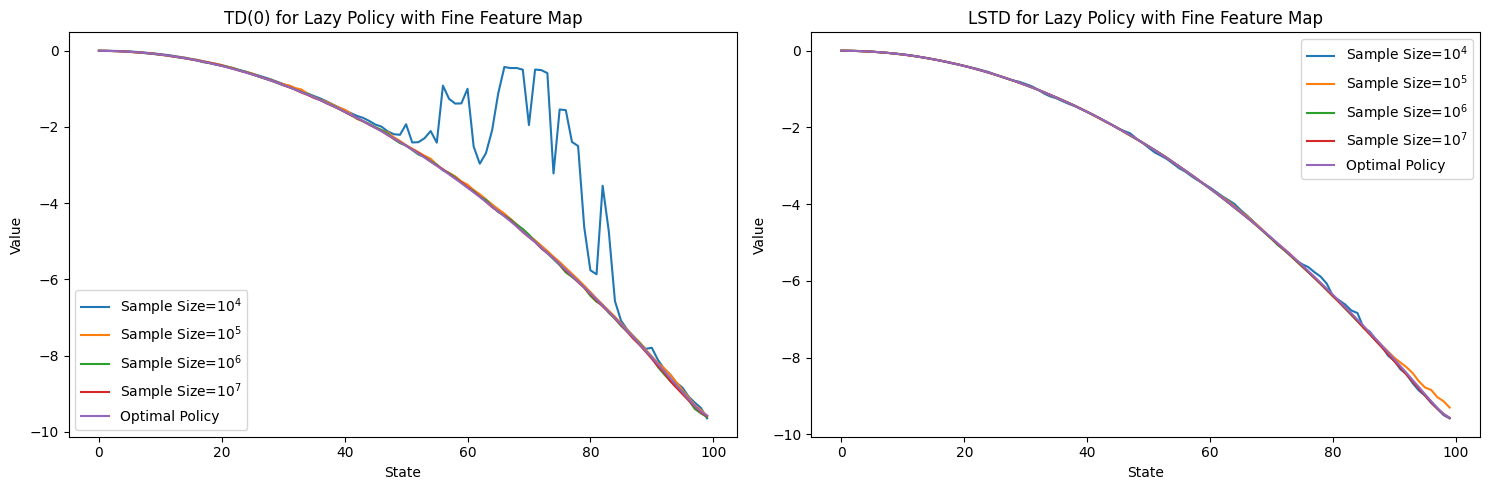

In [13]:
# load the results from a file to avoid re-running the code
results_lazy_fine = np.load('results_lazy_fine.npz', allow_pickle=True)
results_td0_lazy_fine = results_lazy_fine['results_td0'].item()
results_lstd_lazy_fine = results_lazy_fine['results_lstd'].item()
plot_td0_lstd(results_td0_lazy_fine, results_lstd_lazy_fine, stored_values_opt_VI, 'lazy', 'fine', phi_fine, N,
              [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7])

#### Observations for the lazy policy and fine feature map results
- TD(0) exhibits significant variance at lower sample sizes but converges towards the optimal policy with larger samples.
- LSTD provides smoother estimations, indicating higher sample efficiency and stability.
- Both methods approximate the dynamics of the policy effectively as sample size increases.


#### 1.7.2 Plotting the results for the lazy policy and coarse feature map

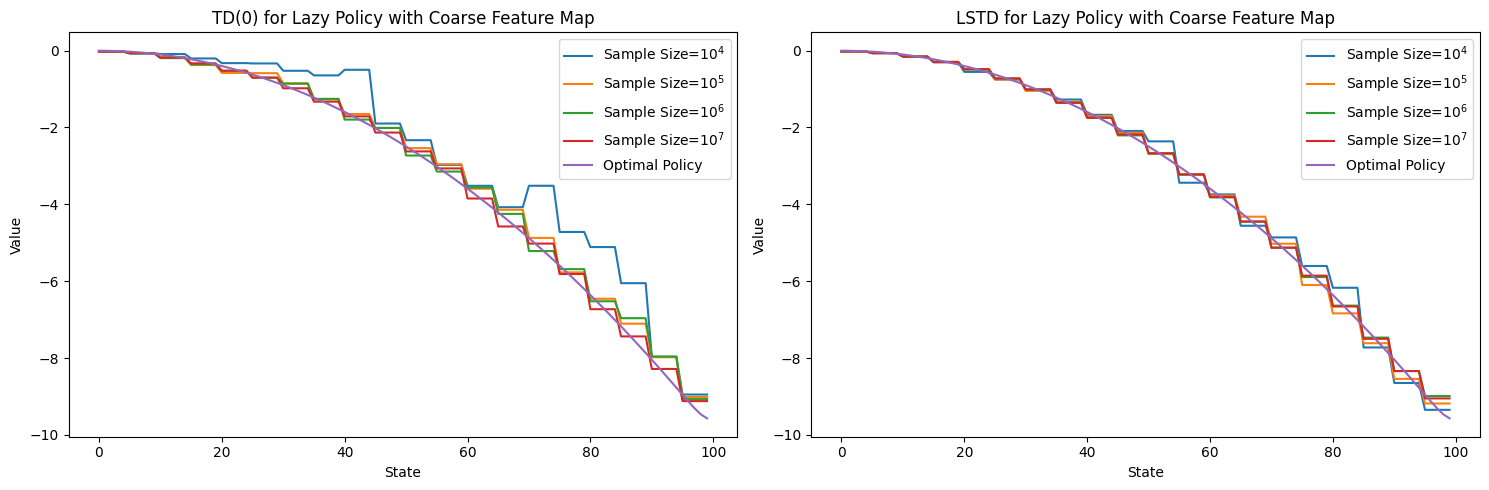

In [14]:
# load the results from a file to avoid re-running the code
results_lazy_coarse = np.load('results_lazy_coarse.npz', allow_pickle=True)
results_td0_lazy_coarse = results_lazy_coarse['results_td0'].item()
results_lstd_lazy_coarse = results_lazy_coarse['results_lstd'].item()
plot_td0_lstd(results_td0_lazy_coarse, results_lstd_lazy_coarse, stored_values_opt_VI, 'lazy', 'coarse', phi_coarse, N, [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7])

#### Observations for the lazy policy and coarse feature map results
- With the coarse feature map, the value function approximations show a step-like behavior due to the less granular state representation.
- LSTD provides a consistent approximation across different sample sizes, aligning closely with the optimal policy.
- The aggregation of states into bins in the coarse feature map results in less detailed but computationally efficient value function estimations.
- Although both methods converge near the optimal policy's value function, the coarse feature map's granularity leads to a less accurate approximation.

#### 1.7.3 Plotting the results for the lazy policy and pwl feature map

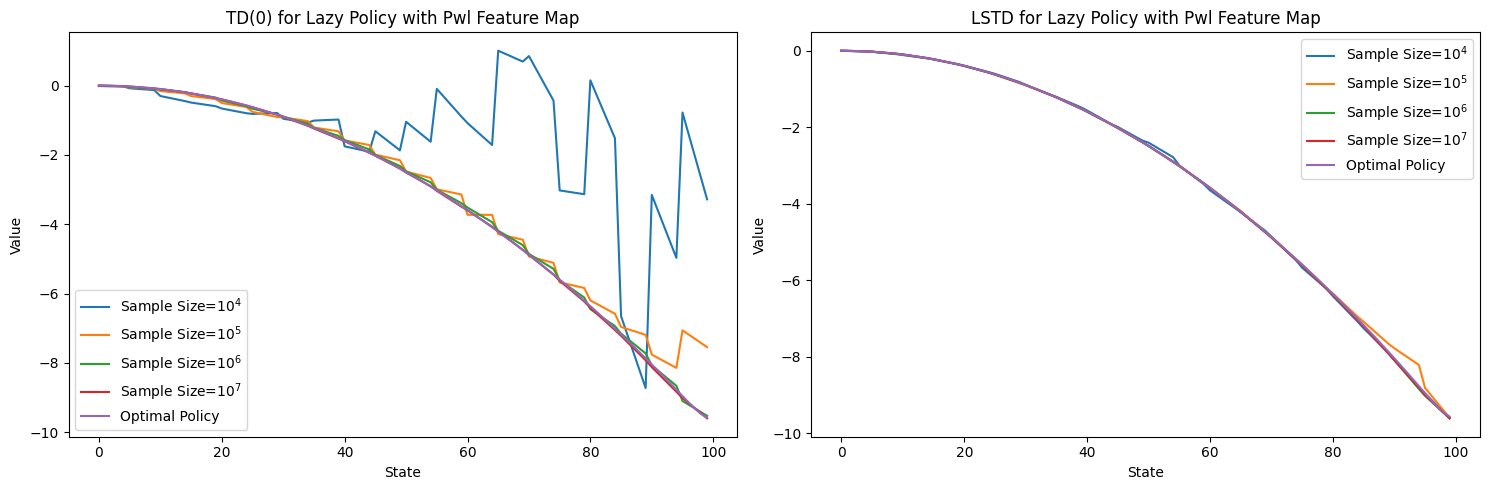

In [15]:
# load the results from a file to avoid re-running the code
results_lazy_pwl = np.load('results_lazy_pwl.npz', allow_pickle=True)
results_td0_lazy_pwl = results_lazy_pwl['results_td0'].item()
results_lstd_lazy_pwl = results_lazy_pwl['results_lstd'].item()
plot_td0_lstd(results_td0_lazy_pwl, results_lstd_lazy_pwl, stored_values_opt_VI, 'lazy', 'pwl', phi_pwl, N,
              [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7])

#### Observations for the lazy policy and pwl feature map results
- The pwl feature map allows for a finer approximation in value function, particularly noticeable in the TD(0) estimations at higher sample sizes.
- LSTD maintains its performance with smooth and stable estimations, showcasing its robustness across different feature maps.

#### 1.7.4 Plotting the results for the aggressive policy and fine feature map

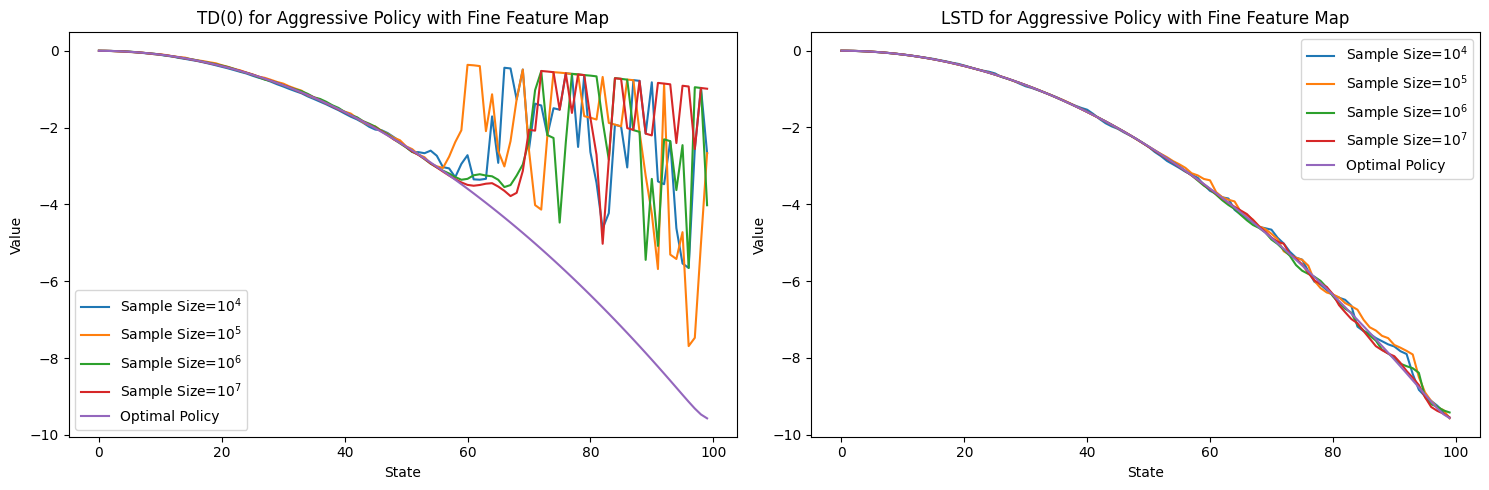

In [16]:
# load the results from a file to avoid re-running the code
results_aggressive_fine = np.load('results_aggressive_fine.npz', allow_pickle=True)
results_td0_aggressive_fine = results_aggressive_fine['results_td0'].item()
results_lstd_aggressive_fine = results_aggressive_fine['results_lstd'].item()
plot_td0_lstd(results_td0_aggressive_fine, results_lstd_aggressive_fine, stored_values_opt_VI, 'aggressive', 'fine', phi_fine, N,
              [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7])

#### Observations for the aggressive policy and fine feature map results
- TD(0) estimations exhibit significant noise and variance, with the estimations for larger sample sizes showing some convergence towards the optimal policy's value function, but still far from it. This can be attributed to the fact that the queue gets small very fast when using the aggressive policy, so there enough samples for the higher queue states to make a correct estimation.
- LSTD, once again, demonstrates smoother estimations, indicating its effectiveness in dealing with variance inherent in TD(0).
- The fine feature map's high resolution captures the aggressive policy's characteristics more accurately with LSTD.

#### 1.7.5 Plotting the results for the aggressive policy and coarse feature map

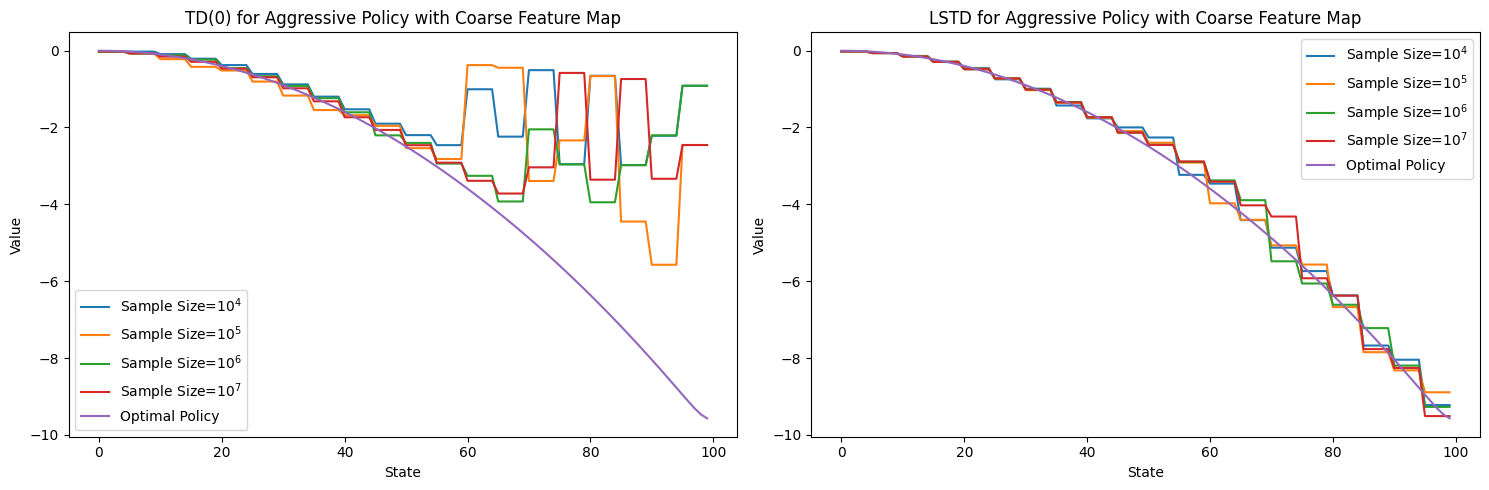

In [17]:
# load the results from a file to avoid re-running the code
results_aggressive_coarse = np.load('results_aggressive_coarse.npz', allow_pickle=True)
results_td0_aggressive_coarse = results_aggressive_coarse['results_td0'].item()
results_lstd_aggressive_coarse = results_aggressive_coarse['results_lstd'].item()
plot_td0_lstd(results_td0_aggressive_coarse, results_lstd_aggressive_coarse, stored_values_opt_VI, 'aggressive', 'coarse', phi_coarse, N, [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7])

#### Observations for the aggressive policy and coarse feature map results
- The coarse feature map leads to blocky estimations in TD(0), with much variance and noise. It does not converge to the optimal policy's value function even with large sample sizes.
- LSTD's estimations are consistent and closely match the optimal policy, emphasizing the method's robustness to feature map granularity. It is also clear that for the larger sample size, the LSTD estimations are very close to the optimal policy's value function.
- The aggressive policy's switch at state 50 is also visible in the coarse feature map's value function estimations in TD(0), which once again this can be attributed to the fact that the queue gets small very fast when using the aggressive policy, so there enough samples for the higher queue states to make a correct estimation.

#### 1.7.6 Plotting the results for the aggressive policy and pwl feature map

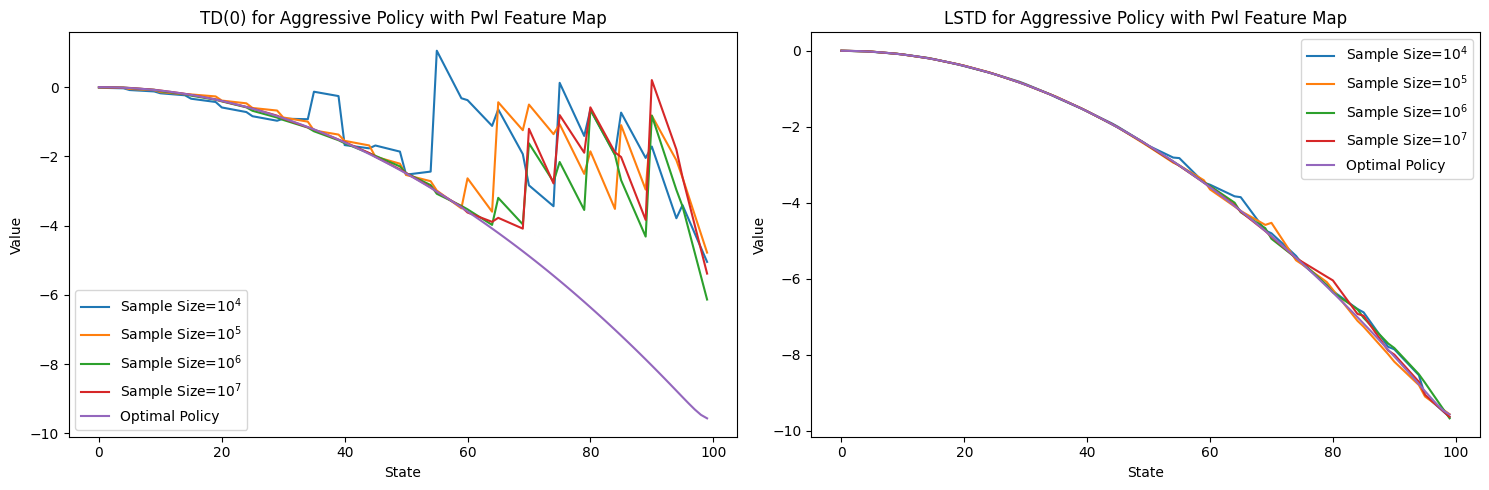

In [18]:
# load the results from a file to avoid re-running the code
results_aggressive_pwl = np.load('results_aggressive_pwl.npz', allow_pickle=True)
results_td0_aggressive_pwl = results_aggressive_pwl['results_td0'].item()
results_lstd_aggressive_pwl = results_aggressive_pwl['results_lstd'].item()
plot_td0_lstd(results_td0_aggressive_pwl, results_lstd_aggressive_pwl, stored_values_opt_VI, 'aggressive', 'pwl', phi_pwl, N, [10 ** 4, 10 ** 5, 10 ** 6, 10 ** 7])

#### Observations for the aggressive policy and pwl feature map results
- The pwl feature map results in TD(0) estimations that reveal the policy's switch at state 50 is also apparent for the same reason as with the other two feature maps, but with less noise than the fine map. Similarly to the other feature maps with the aggressive policy, the TD(0) estimations do not converge to the optimal policy's value function even with large sample sizes.
- LSTD shows minimal variance across sample sizes and aligns closely with the optimal policy's value function.

## PROBLEM 2: *Approximate Policy Iteration*

### 2.1 Policy Improvement

#### 2.1.1 Q-function

In [19]:
def Q_function(V, x, a, gamma, p, q_low, q_high):
    # Compute the Q-value estimate based on V
    if a == 'alow':
        q = q_low
    else:  # 'ahigh'
        q = q_high

    return reward(x, a) + gamma * (
            (1 - p) * q * V[trunc(x - 1)] +
            (1 - p) * (1 - q) * V[x] +
            p * q * V[x] +
            p * (1 - q) * V[trunc(x + 1)]
    )

#### 2.1.2 Greedy Policy

In [22]:
def greedy_policy(V, N, gamma, p, q_low, q_high, A):
    # Compute the greedy policy based on V
    new_policy = np.zeros((N, A))  # Initialize the new policy with all zeros
    
    # Iterate over all states and actions to determine the greedy policy (i.e., the policy that maximizes the Q-value)
    for x in range(N):
        q_values = [Q_function(V, x, 'alow', gamma, p, q_low, q_high),
                    Q_function(V, x, 'ahigh', gamma, p, q_low, q_high)]
        action = np.argmax(q_values)
        new_policy[x, action] = 1
    return new_policy

#### 2.1.3 Approximate Policy Iteration

In [23]:
def approximate_policy_iteration(N, A, gamma, p, q_low, q_high, initial_policy, feature_map, num_iterations):
    # Set the iteration count k to zero
    k = 0
    # Initialize the policy
    policy = initial_policy

    # Initialize lists to store value functions and policies for plotting
    V_history = []
    policy_history = []
    iteration = []

    # Generate initial value function estimate
    V_weights = LSTD(policy, feature_map, 10 ** 5, N, gamma)
    feature_matrix = np.array([feature_map(x, N) for x in range(N)])
    V_k = np.dot(feature_matrix, V_weights) # same as feature_matrix @ V_weights

    # Iterate until the specified number of iterations is reached
    while k < num_iterations:
        # Policy Improvement
        policy = greedy_policy(V_k, N, gamma, p, q_low, q_high, A)
        # Policy Evaluation
        V_weights = LSTD(policy, feature_map, 10 ** 5, N, gamma)
        V_k = feature_matrix @ V_weights # same as np.dot(feature_matrix, V_weights)
        # Store value functions and policies at iterations of interest
        if k == 9 or k == 99:
            iteration.append(k)
            V_history.append(V_k)
            policy_history.append(policy)
        # Print message to indicate progress every 10 iterations
        if k % 10 == 0:
            print(f'Finished iteration {k} of {num_iterations}')
        # Increment the iteration count
        k += 1

    # Return the required data for plotting
    return V_history, policy_history, iteration

### 2.2 Approximate Policy Iteration Estimation

#### 2.2.1 Approximate Policy Iteration Estimation for the lazy policy and fine feature map

In [46]:
# Run the policy iteration for the lazy policy and fine feature map
V_history, policy_history, iteration = approximate_policy_iteration(
    N, A, gamma, p, q_low, q_high, initial_policy=pi_lazy, feature_map=phi_fine, num_iterations=100)

# Save the results to a file
np.savez('results_api_lazy_fine.npz', V_history=V_history, policy_history=policy_history, iteration=iteration)

Finished iteration 0 of 100
Finished iteration 10 of 100
Finished iteration 20 of 100
Finished iteration 30 of 100
Finished iteration 40 of 100
Finished iteration 50 of 100
Finished iteration 60 of 100
Finished iteration 70 of 100
Finished iteration 80 of 100
Finished iteration 90 of 100


#### 2.2.2 Approximate Policy Iteration Estimation for the lazy policy and coarse feature map

In [42]:
# Run the policy iteration for the lazy policy and coarse feature map
V_history, policy_history, iteration = approximate_policy_iteration(
    N, A, gamma, p, q_low, q_high, initial_policy=pi_lazy, feature_map=phi_coarse, num_iterations=100)

# Save the results to a file
np.savez('results_api_lazy_coarse.npz', V_history=V_history, policy_history=policy_history, iteration=iteration)

Finished iteration 0 of 100
Finished iteration 10 of 100
Finished iteration 20 of 100
Finished iteration 30 of 100
Finished iteration 40 of 100
Finished iteration 50 of 100
Finished iteration 60 of 100
Finished iteration 70 of 100
Finished iteration 80 of 100
Finished iteration 90 of 100


#### 2.2.3 Approximate Policy Iteration Estimation for the lazy policy and pwl feature map

In [15]:
# Run the policy iteration for the lazy policy and pwl feature map
V_history, policy_history, iteration = approximate_policy_iteration(
    N, A, gamma, p, q_low, q_high, initial_policy=pi_lazy, feature_map=phi_pwl, num_iterations=100)

# Save the results to a file
np.savez('results_api_lazy_pwl.npz', V_history=V_history, policy_history=policy_history, iteration = iteration)

Finished iteration 0 of 100
Finished iteration 10 of 100
Finished iteration 20 of 100
Finished iteration 30 of 100
Finished iteration 40 of 100
Finished iteration 50 of 100
Finished iteration 60 of 100
Finished iteration 70 of 100
Finished iteration 80 of 100
Finished iteration 90 of 100


### 2.3 Plotting the Results

#### 2.3.1 Function for plotting the value functions

In [25]:
# Load the opt_policy_VI from problem set 1 to compare with the results
opt_policy_VI = np.load('opt_policy_VI.npy') # numpy ndarray
# get the values from the ndarray
opt_policy_service_rates = [q_low if opt_policy_VI[x] == 0 else q_high for x in range(N)]

# Load the results for opt_policy_VI from problem set 1 to compare with the results
stored_values_opt_VI = np.load('stored_values_opt_VI.npy', allow_pickle=True).item()

#Print the optimal policy in terms of service rates
print('Optimal Policy Service Rates')
for k, v in stored_values_opt_VI.items():
    print(f'{k}: {v}')

Optimal Policy Service Rates
100: [-3.18549630e-03 -4.63062656e-03 -7.78176347e-03 -1.27771201e-02
 -1.96899220e-02 -2.85589639e-02 -3.94047989e-02 -5.22383158e-02
 -6.70652833e-02 -8.38887571e-02 -1.02710356e-01 -1.23530938e-01
 -1.46350956e-01 -1.71170651e-01 -1.97990151e-01 -2.26809522e-01
 -2.57628800e-01 -2.90448004e-01 -3.25267145e-01 -3.62086226e-01
 -4.00905251e-01 -4.41724222e-01 -4.84543138e-01 -5.29362001e-01
 -5.76180811e-01 -6.24999568e-01 -6.75818271e-01 -7.28636921e-01
 -7.83455518e-01 -8.40274062e-01 -8.99092553e-01 -9.59910990e-01
 -1.02272937e+00 -1.08754771e+00 -1.15436598e+00 -1.22318421e+00
 -1.29400238e+00 -1.36682050e+00 -1.44163857e+00 -1.51845658e+00
 -1.59727454e+00 -1.67809245e+00 -1.76091030e+00 -1.84572810e+00
 -1.93254584e+00 -2.02136354e+00 -2.11218117e+00 -2.20499875e+00
 -2.29981626e+00 -2.39663370e+00 -2.49545103e+00 -2.59626820e+00
 -2.69908510e+00 -2.80390150e+00 -2.91071695e+00 -3.01953058e+00
 -3.13034060e+00 -3.24314355e+00 -3.35793255e+00 -3.4746

In [26]:
def plot_value_functions(V_history, feature_map_name, stored_values_opt_VI):
    plt.figure(figsize=(12, 6))
    labels = ['10 iterations', '100 iterations']

    for V, label in zip(V_history, labels):
        plt.plot(range(N), V, label=f'{feature_map_name} - {label}')
    
    for v_opt in stored_values_opt_VI.values():
        plt.plot(range(N), v_opt, label='Optimal Policy', color='purple')

    plt.title(f'Value Function Comparison - {feature_map_name}')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

#### 2.3.2 Function for plotting the policies

In [27]:
def plot_service_rates(policy_history, q_low, q_high, feature_map_name, opt_policy_VI):
    
    plt.figure(figsize=(12,6))
    labels = ['10 iterations', '100 iterations']
    
    for policy, label in zip(policy_history, labels):
        service_rates = [q_low if policy[x, 0] == 1 else q_high for x in range(N)]
        plt.plot(range(N), service_rates, label=f'{feature_map_name} - {label}')
        
    # Also plot the optimal service rates from the previous problem set for comparison
    plt.plot(range(N), opt_policy_VI, label='Optimal Policy', color='purple')

    plt.title(f'Service Rates Comparison - {feature_map_name}')
    plt.xlabel('State')
    plt.ylabel('Service Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


#### 2.3.3 Function for plotting both the value functions and the service rates

In [28]:
def plot_all(feature_map_name, V_history, policy_history, stored_values_opt_VI, opt_policy_service_rates, iteration=None):
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the value functions
    labels = ['10 iterations', '100 iterations']
    for V, label in zip(V_history, labels):
        ax1.plot(range(N), V, label=f'{feature_map_name} - {label}')

    for v_opt in stored_values_opt_VI.values():
        ax1.plot(range(N), v_opt, label='Optimal Policy', color='purple')

    ax1.set_title(f'Value Function Comparison - {feature_map_name}')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Value')
    ax1.legend()

    # Plot the service rates
    labels = ['10 iterations', '100 iterations']
    for policy, label in zip(policy_history, labels):
        service_rates = [q_low if policy[x, 0] == 1 else q_high for x in range(N)]
        ax2.plot(range(N), service_rates, label=f'{feature_map_name} - {label}')

    # Also plot the optimal service rates from the previous problem set
    ax2.plot(range(N), opt_policy_service_rates, label='Optimal Policy', color='purple')
    
    ax2.set_title(f'Service Rates Comparison - {feature_map_name}')
    ax2.set_xlabel('State')
    ax2.set_ylabel('Service Rate')
    ax2.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()
    

#### 2.3.4 Plotting the results for the lazy policy and fine feature map

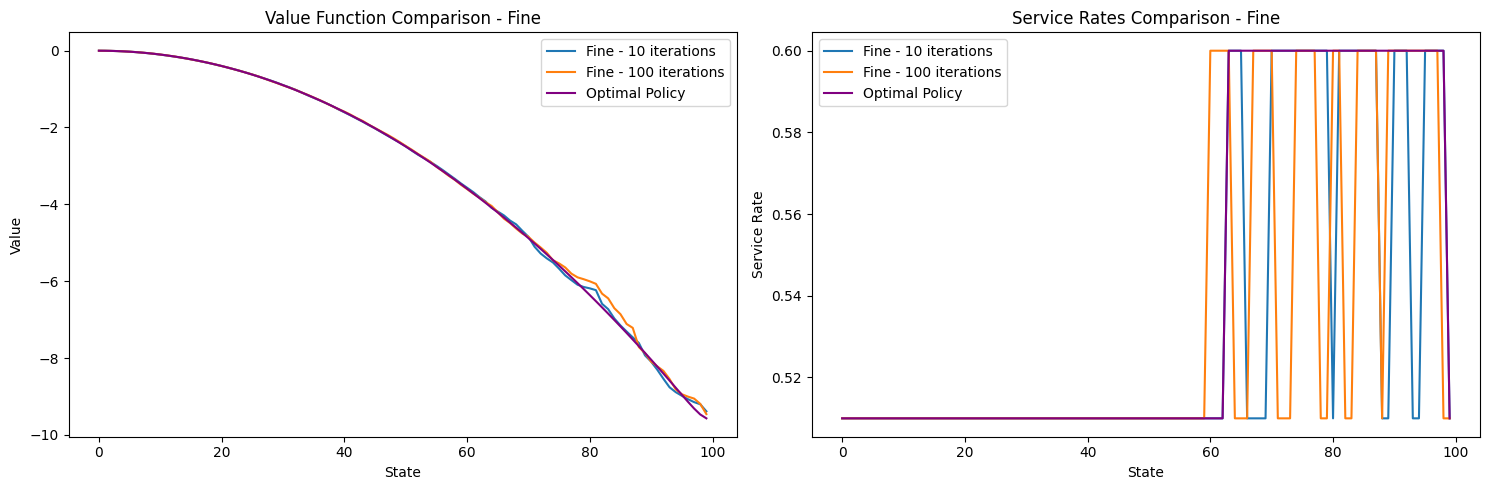

In [29]:
# Load the results from a file to avoid re-running the code
results_api_lazy_fine = np.load('results_api_lazy_fine.npz', allow_pickle=True)
V_history = results_api_lazy_fine['V_history']
policy_history = results_api_lazy_fine['policy_history']

# Plot both the value functions and the service rates
plot_all('Fine', V_history, policy_history, stored_values_opt_VI, opt_policy_service_rates)

#### Observations for the fine feature map results for API:
##### Value Function Comparison
- The value function curves for 10 and 100 iterations are closely aligned, which indicates that the value function stabilizes quickly. This could suggest that additional iterations beyond 10 do not contribute significantly to the improvement of the policy's value estimate.
The closeness of both iteration curves to the optimal policy curve demonstrates that the fine feature map is capable of capturing the essence of the optimal policy well.
##### Service Rates Comparison
- The service rate plot shows the policy after 10 and 100 iterations attempting to follow the structure of the optimal policy, particularly around the state 60 transition. This suggests that the fine feature map picks up on the critical threshold in the decision process.
- However, after state 60, the service rates for both 10 and 100 iterations display fluctuations instead of remaining at a higher plateau like the optimal policy. These fluctuations could indicate that the algorithm might be overfitting rather than learning the underlying policy structure.

#### 2.3.5 Plotting the results for the lazy policy and coarse feature map

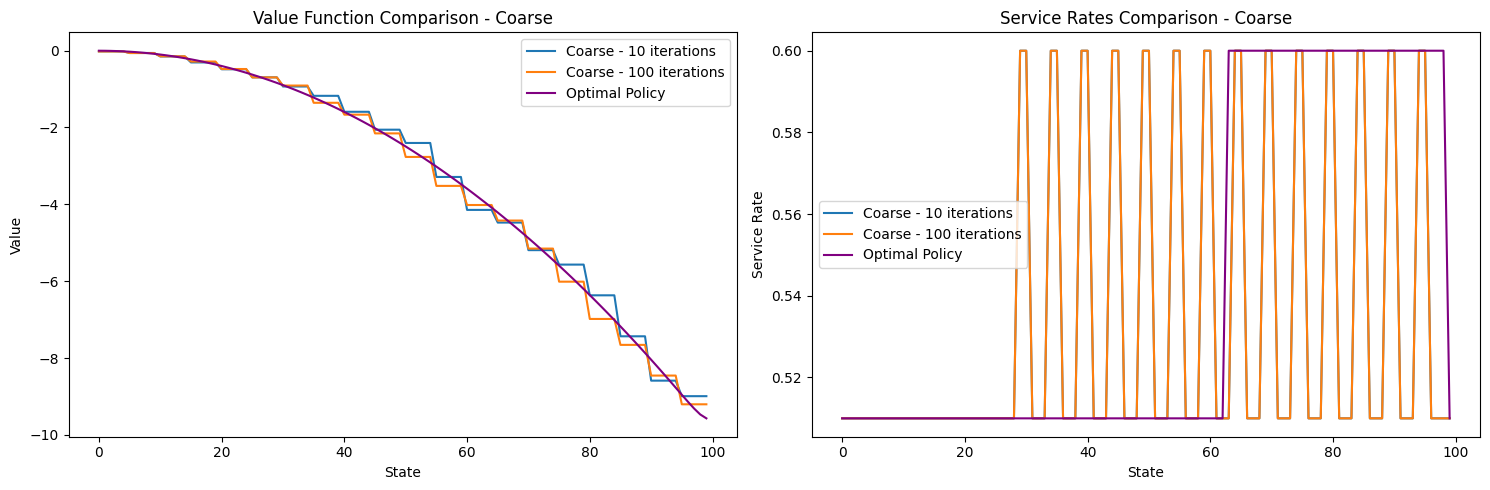

In [30]:
# Load the results from a file to avoid re-running the code
results_api_lazy_coarse = np.load('results_api_lazy_coarse.npz', allow_pickle=True)
V_history = results_api_lazy_coarse['V_history']
policy_history = results_api_lazy_coarse['policy_history']

# Function that plots both the value functions and the service rates
plot_all('Coarse', V_history, policy_history, stored_values_opt_VI, opt_policy_service_rates)

#### Observations for the coarse feature map results for API:
##### Value Function Comparison
- The value function after 100 iterations is visibly closer to the optimal policy than after 10 iterations. This improvement indicates that additional iterations are refining the policy evaluation. 
- Despite the improvement, the value function after 100 iterations is still not as close to the optimal policy as the fine feature map's value function. This result suggests that the coarse feature map is not as effective in capturing the optimal policy's essence.
##### Service Rates Comparison
- The service rates for both 10 and 100 iterations show a pattern starting from state 30, which is very different from the optimal policy's service rates. This fluctuation doesn't align with the optimal policy, suggesting that the policy derived from the coarse feature map might be responding to nois within the sampled data, rather than the true underlying policy structure.
- The near-identical service rates for 10 and 100 iterations indicate that additional iterations do not significantly change the policy's decisions.

#### 2.3.5 Plotting the results for the lazy policy and pwl feature map

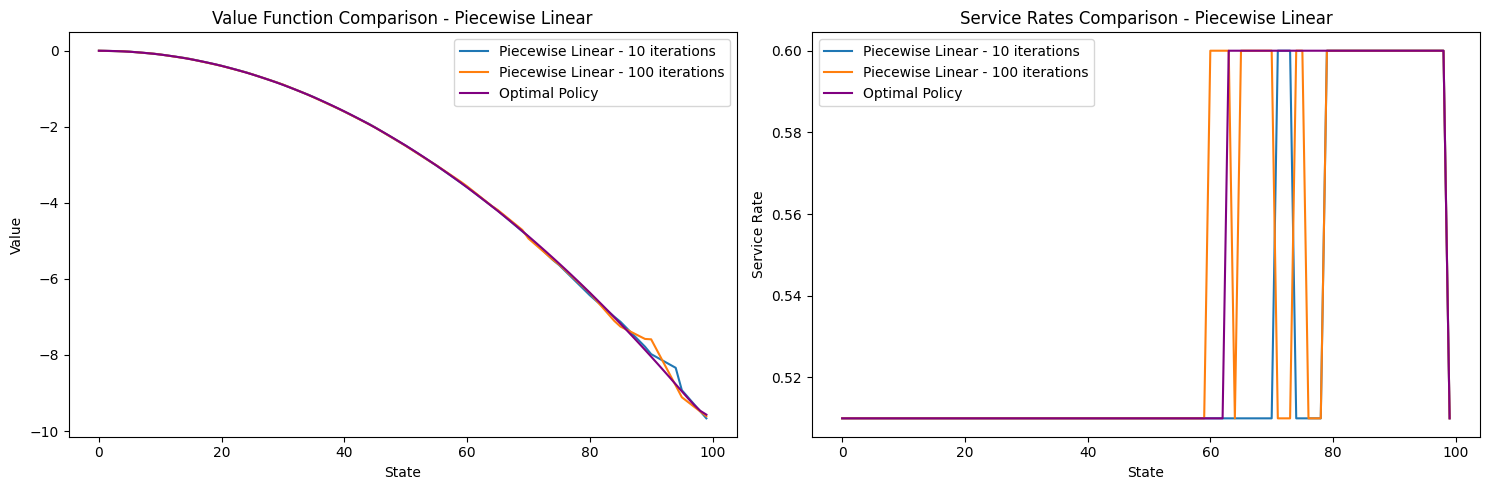

In [31]:
# Load the results from a file to avoid re-running the code
results_api_lazy_pwl = np.load('results_api_lazy_pwl.npz', allow_pickle=True)
V_history = results_api_lazy_pwl['V_history']
policy_history = results_api_lazy_pwl['policy_history']

# Plot both the value functions and the service rates
plot_all('Piecewise Linear', V_history, policy_history, stored_values_opt_VI, opt_policy_service_rates)

#### Observations for the pwl feature map results for API:
##### Value Function Comparison
- The value function for the PWL feature map after 10 and 100 iterations is closely aligned with the optimal policy, showing that the PWL map provides a good approximation of the value function across states.
- The smoothness of the curve indicates that the PWL map captures the transitional dynamics of the policy without introducing significant noise or overfitting.
##### Service Rates Comparison
- The service rate for the PWL feature map changes around state 60, similar to the optimal policy, suggesting that the PWL map is capturing the critical transition in policy behavior effectively.
- Between states 60 to 80, there are some fluctuations in the service rate, resembling the pattern observed in the fine map. These fluctuations could also be the result of noise in the sample data.
- Importantly, after state 80, the service rate stabilizes and closely matches the optimal policy again. This is an improvement over the fine map, indicating that the PWL map may provide a better balance between capturing the essential aspects of the optimal policy and avoiding overfitting.
- The fact that the service rates for 10 and 100 iterations are quite similar after state 80 suggests that the policy is converging to a stable strategy that aligns well with the optimal policy.